### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym


### Encoding

In [7]:
env = gym.make('MinAtar/Breakout-v1')
#get info on state and action space
print(env.observation_space)
print(env.action_space)

Box(False, True, (10, 10, 4), bool)
Discrete(3)


In [13]:
def get_bit_depth_for_gym_env(env_name):
    """
    Determines the bit depth required for encoding the state and action spaces
    of a discrete OpenAI Gym environment or a MinAtar environment.
    
    Parameters:
    env_name (str): The name of the gym environment.
    
    Returns:
    int, int: The bit depth for the state space and the action space.
    """
    # Load the gym environment
    env = gym.make(env_name)
    
    # Determine the size of the state and action spaces
    if isinstance(env.observation_space, gym.spaces.Discrete):
        state_space_size = env.observation_space.n
        state_bit_depth = int(np.ceil(np.log2(state_space_size)))
    elif isinstance(env.observation_space, gym.spaces.Box):
        # For Box space, calculate the total number of boolean elements
        state_space_size = np.prod(env.observation_space.shape)
        state_bit_depth = int(state_space_size)  # Each element is a boolean, so it's 1 bit
    else:
        state_bit_depth = None
    
    if isinstance(env.action_space, gym.spaces.Discrete):
        action_space_size = env.action_space.n
        action_bit_depth = int(np.ceil(np.log2(action_space_size)))
    else:
        action_bit_depth = None
    
    return state_bit_depth, action_bit_depth


def convert_box_to_grid(box_observation):
    """
    Converts a box observation space from a Mini Atari environment 
    into a binary grid with multiple channels.

    :param box_observation: A numpy array representing the box observation space.
    :return: A binary grid representation with multiple channels.
    """
    # The input is expected to be a boolean numpy array of shape (10, 10, 4)
    # where 10x10 is the grid size and 4 is the number of channels (categories).
    
    # Convert the boolean values to integers (0s and 1s)
    binary_grid = box_observation.astype(int)
    
    return binary_grid


State bit depth: 400, Max value: 2.58e+120
Action bit depth: 2, Max value: 4


In [14]:
#TEST

# #env_name = 'ALE/Breakout-v5'
# env_name = 'MinAtar/Breakout-v1'
# state_bit_depth, action_bit_depth = get_bit_depth_for_gym_env(env_name)
# # now print out the bit depth of the state and action space (alongisde their max decimal value they can represent, but in scientific notation if greater than 9999)

# # Calculate max decimal value
# state_max_value = 2**state_bit_depth 
# action_max_value = 2**action_bit_depth

# # Convert to scientific notation if greater than 9999
# state_max_value = "{:.2e}".format(state_max_value) if state_max_value > 9999 else state_max_value
# action_max_value = "{:.2e}".format(action_max_value) if action_max_value > 9999 else action_max_value

# # Print bit depth and max decimal value
# print(f"State bit depth: {state_bit_depth}, Max value: {state_max_value}")
# print(f"Action bit depth: {action_bit_depth}, Max value: {action_max_value}")

In [15]:
def int2analog_bit(integer_value, bit_depth):
    """
    Encodes an integer value into analog bits.
    
    Parameters:
    integer_value (int): The integer value to encode.
    bit_depth (int): The number of bits to use for the binary representation.
    
    Returns:
    np.array: The encoded analog bits.
    """
    # Convert the integer to binary representation and pad with zeros to match the bit depth
    binary_string = format(integer_value, f'0{bit_depth}b')
    
    # Convert the binary string to a list of integers and then to a numpy array
    binary_list = [int(bit) for bit in binary_string]
    analog_bits = np.array(binary_list)
    
    # Convert binary bits (0, 1) to analog bits (-1, 1)
    analog_bits = analog_bits * 2 - 1
    
    return analog_bits


def binbox2analog_bit(box_observation):
    """
    Converts the box observation into analog bits.

    Parameters:
    - box_observation: A numpy array representing the binary box observation space.
    - bit_depth: The bit depth for each channel in the binary grid.

    Returns:
    - A numpy array representing the analog bits for the box observation.
    """
    box_grid = convert_box_to_grid(box_observation)
    analog_bits_grid = (box_grid * 2) - 1

    return analog_bits_grid


def analog_bit2int(analog_bits):
    """
    Decodes analog bits back into an integer value.
    
    Parameters:
    analog_bits (np.array): The analog bits to decode.
    
    Returns:
    int: The decoded integer value.
    """
    # Convert analog bits (-1, 1) to binary bits (0, 1)
    binary_bits = (analog_bits + 1) // 2
    
    # Convert the binary bits to a binary string
    binary_string = ''.join(str(int(bit)) for bit in binary_bits)
    
    # Convert the binary string to an integer
    integer_value = int(binary_string, 2)
    
    return integer_value


def threshold_analog_bits(analog_bits):
    """
    Applies thresholding to analog bits to convert them back to -1 or 1.
    
    Parameters:
    analog_bits (np.array): The array of analog bits with continuous values.
    
    Returns:
    np.array: The thresholded analog bits.
    """
    # Apply thresholding: values above 0 become 1, values below 0 become -1
    thresholded_bits = np.where(analog_bits > 0, 1, -1)
    
    return thresholded_bits


    

IndentationError: expected an indented block (<ipython-input-15-9978b30b7061>, line 25)

### Test

In [21]:


import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.preprocessing import preprocess_obs

def convert_box_to_grid(box_observation):
    """
    Converts a box observation space from a Mini Atari environment 
    into a binary grid with multiple channels.
    """
    binary_grid = box_observation.astype(int)
    return binary_grid

def binbox2analog_bit(box_observation):
    """
    Converts the box observation into analog bits.
    """
    box_grid = convert_box_to_grid(box_observation)
    analog_bits_grid = (box_grid * 2) - 1
    return analog_bits_grid.flatten()

class CustomPreprocessEnv(gym.ObservationWrapper):
    """
    A custom environment wrapper that preprocesses observations.
    """
    def __init__(self, env):
        super(CustomPreprocessEnv, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=-1, high=1, 
                                                shape=(400,), dtype=np.float32)

    def observation(self, observation):
        return binbox2analog_bit(observation)

def make_env(env_id, rank):
    """
    Utility function for multiprocessed env.
    """
    def _init():
        env = gym.make(env_id)
        env = CustomPreprocessEnv(env)
        return env
    return _init

env_id = "MinAtar/Breakout-v1"
num_cpu = 4  # Number of processes to use
env = DummyVecEnv([make_env(env_id, i) for i in range(num_cpu)])
env = VecFrameStack(env, n_stack=4)

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=25000)

obs = env.reset()
terminated = False
truncated = False

while not terminated and not truncated:
    print("DEBUG 1")
    try:
        # Assuming the first element in the tuple is the observation you need
        processed_obs = obs[0] if isinstance(obs, tuple) else obs

        # Debugging: Print processed observation's type and shape
        print(f"Processed Observation type: {type(processed_obs)}, Processed Observation shape: {processed_obs.shape if hasattr(processed_obs, 'shape') else 'N/A'}")
        
        action, _ = model.predict(processed_obs, deterministic=True)
        obs, reward, terminated, truncated = env.step(action)
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        break
print("DEBUG 2")

env.close()



Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7443     |
|    time_elapsed     | 0        |
|    total_timesteps  | 48       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 7640     |
|    time_elapsed     | 0        |
|    total_timesteps  | 72       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 8363     |
|    time_elapsed     | 0        |
|    total_timesteps  | 112      |
----------------------------------
----------------------------------
| r

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.9     |
|    ep_rew_mean     | 0.48     |
| time/              |          |
|    fps             | 1436     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 0.54        |
| time/                   |             |
|    fps                  | 1106        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008431599 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss   

c:\Users\Damien Hood\AppData\Local\Programs\Python\Python39\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.game to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.game` for environment variables or `env.get_wrapper_attr('game')` that will search the reminding wrappers.
  logger.warn(


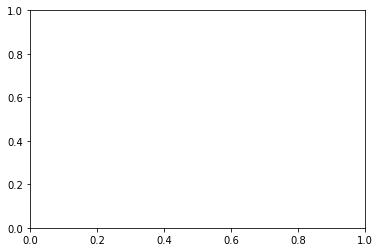

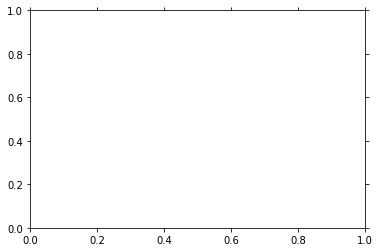

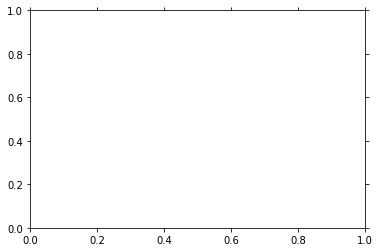

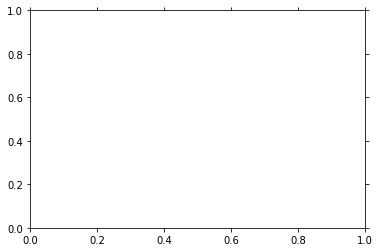

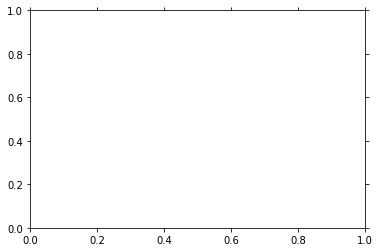

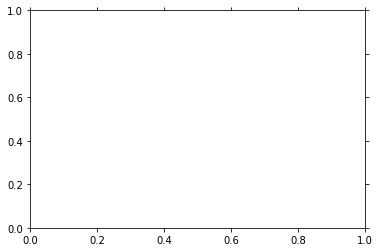

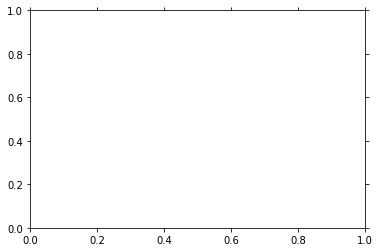

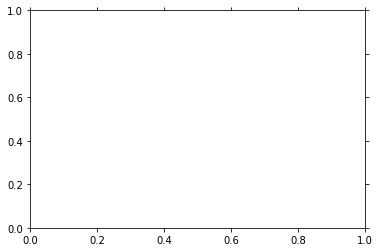

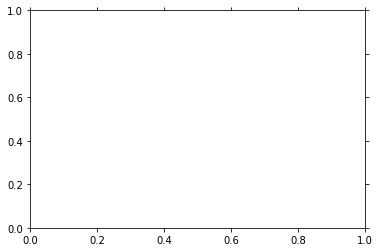

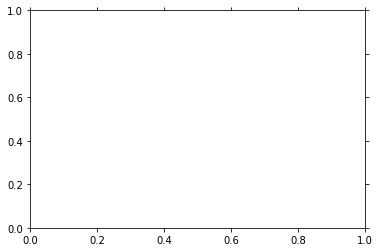

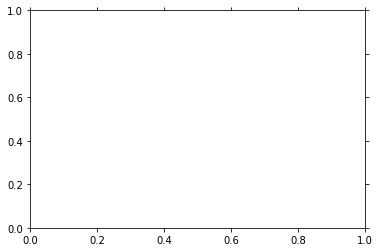

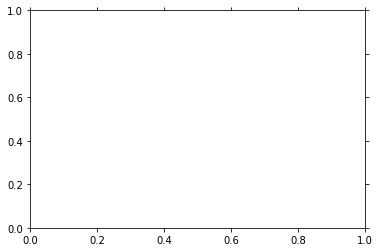

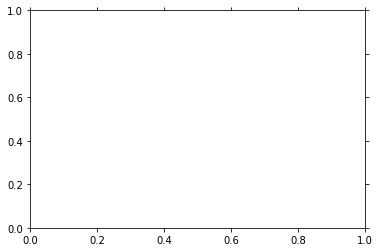

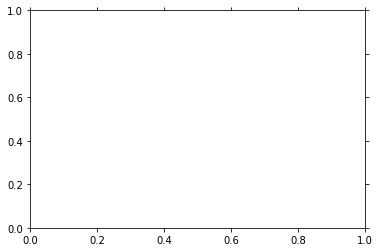

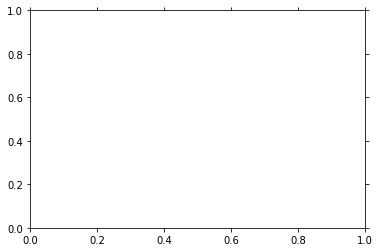

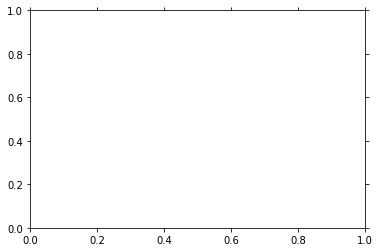

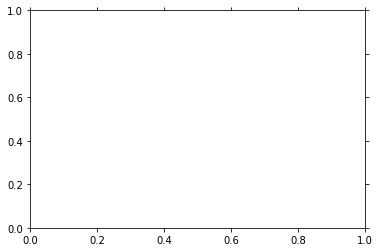

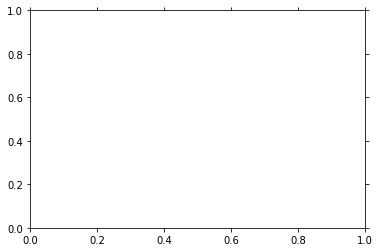

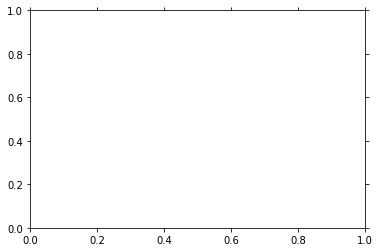

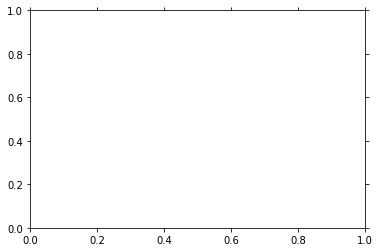

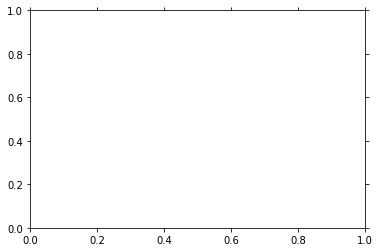

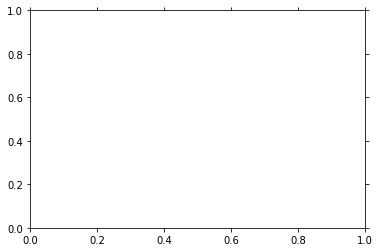

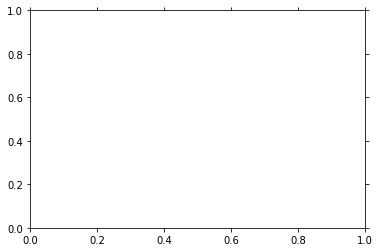

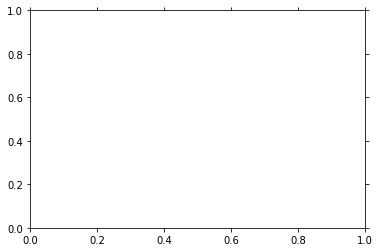

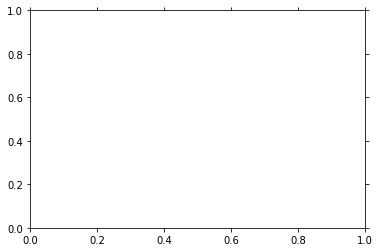

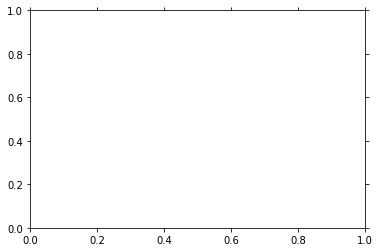

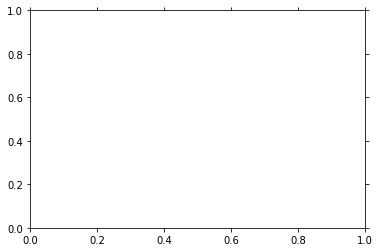

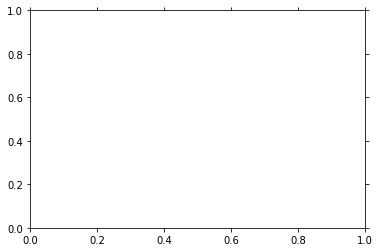

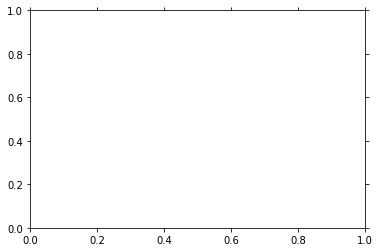

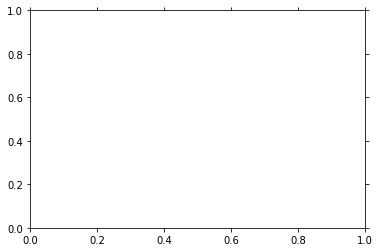

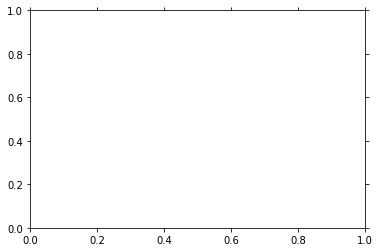

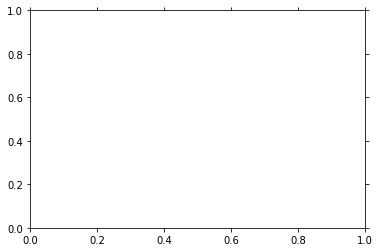

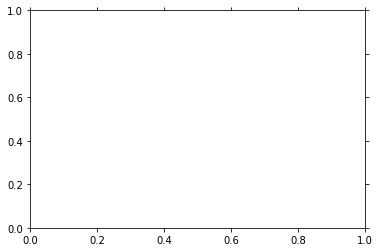

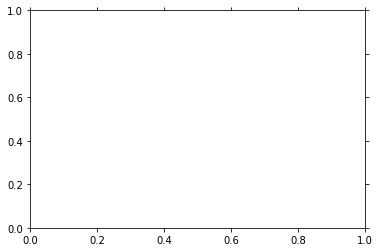

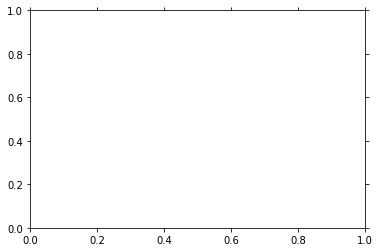

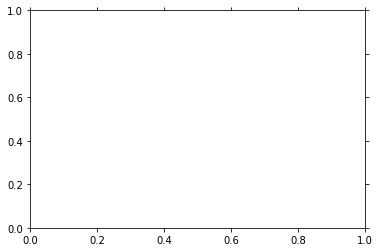

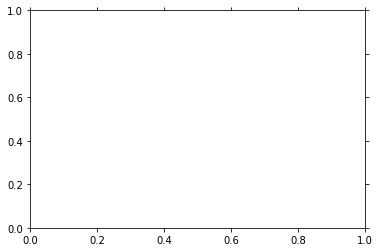

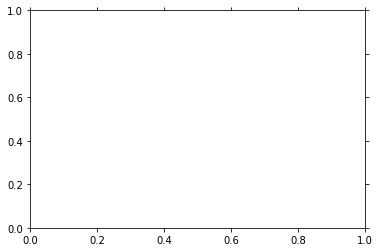

0

In [23]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.preprocessing import preprocess_obs

def convert_box_to_grid(box_observation):
    """
    Converts a box observation space from a Mini Atari environment 
    into a binary grid with multiple channels.
    """
    binary_grid = box_observation.astype(int)
    return binary_grid

def binbox2analog_bit(box_observation):
    """
    Converts the box observation into analog bits.
    """
    box_grid = convert_box_to_grid(box_observation)
    analog_bits_grid = (box_grid * 2) - 1
    return analog_bits_grid.flatten()

env = gym.make("MinAtar/Breakout-v1")

model = PPO("MlpPolicy", env, verbose=1)

model.learn(total_timesteps=25000)


obs = env.reset()
terminated = False
truncated = False

while not terminated and not truncated:
    try:
        # Assuming the first element in the tuple is the observation you need
        processed_obs = obs[0] if isinstance(obs, tuple) else obs

        # Debugging: Print processed observation's type and shape
        #print(f"Processed Observation type: {type(processed_obs)}, Processed Observation shape: {processed_obs.shape if hasattr(processed_obs, 'shape') else 'N/A'}")
        
        action, _ = model.predict(processed_obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        env.game.display_state(50)
    except Exception as e:
        print(f"Error during prediction: {e}")
        break
env.game.close_display()
env.close()
